In [2]:
#import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle

In [3]:
#read data
data = pd.read_csv('../csv-data/data.csv') 

In [4]:
# handle oddometer feature
def meter_handling(meter):
    thousand_exp = ['الف' ,'الاف','ألف','آلف']
    value = re.sub("|".join(thousand_exp), "000", meter).replace(' ', '')
    value =''.join(re.findall("\d+" , meter)).replace(' ','')
    if value == '':
        return np.nan
    else: 
        return int(value)


In [5]:
# handle previous owners feature
def owners_handling(owners):
  
    try:
        value = int(owners)
        return value 
    except :
        if owners is np.nan:
            return owners
        elif re.search(r'أول|اول|۱|1|واحد', owners):
            return 1 
        elif re.search(r'ثاني|تاني|۲|2', owners):
            return 2 
        elif re.search(r'ثالث|تالت|ثلاث|تلاث|3|۳', owners):
            return int(3)
        elif re.search(r'رابع|اربع|4|٤', owners):
            return 4 
        elif re.search(r'خامس|خمس|٥|5', owners):
            return 5 
        elif re.search(r'سادس|ستة|٦|6', owners):
            return 6 
        elif re.search(r'سابع|سبع|۷|7', owners):
            return 7 
        elif re.search(r'ثامن|تامن|ثمن|تمن|۸|8', owners):
            return 8 
        elif re.search(r'تاسع|تسع|۹|9', owners):
            return 9 
        elif re.search(r'عشر|عاشر|۱۰|10', owners):
            return 10 
        elif re.search(r'ستيراد|مستورد|جديد|صفر|غير|شرك|Zero|0|۰|مش|لا', owners):
            return 0
        else:
            return np.nan

In [6]:
# handle passenger fearure
def passengers_handling(passengers):
    try:
        if passengers == '1٠4 ':
            return 5
        if passengers == '7.1 ':
            return 8
        if passengers == (7, 1):
            return 8
        return(int(passengers))
        
    except:
        try:
            return(eval(passengers))
        except:
            if type(passengers) == str:
                passengers_ = passengers.replace('مثال:' , '')
                if '+' in passengers_:
                    r = passengers_.split('+')
                    return(int(r[0])+int(r[1]))
                else:
                    passengers__= 0
                    list_of_numbers = ''.join(re.findall("\d+" , passengers_))
                    for num in list_of_numbers:
                        passengers__ += int(num)
                    return passengers__


In [7]:
# take first part of car name 
def name_handle(name):
    return name.split(' ')[0]


In [8]:
#function for OnHotEncoding
def one_hot_encoding(data, column):
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(data[[column]])
    data[ohe.categories_[0]] = transformed.toarray()
    data.drop(column, inplace=True, axis=1)
    return data

In [9]:
# data to encode
data_before_encode = data.copy()

In [10]:
# unique values of previous owners bafore handling
data_before_encode['prev_owners'].unique()

array(['يد اولى ', 'يد ثانيه ', '3 ', 'ثالثه ', '٣ ', '٤ ', '6 ',
       'يد ثانية ', '٢ ', 'اولى  ', 'اولى ', '0 ', 'يد 5 ', 'يد 4 ',
       '11 ', '2 ', 'ثانية ', 'يد ثالثة ', 'يد 2 ', 'يد تانيه  ', '1 ',
       'يد أولى  ', 'يد٢ ', 'ايد اولى  ', 'يد 0 ', '5 ', 'يد اولى  ',
       'يد ثالثه ', '--- ', '03 ', 'يد أولى ', 'يد ثالثة  ', 'ايد ثانيه ',
       '000 ', 'يد٣ ', '، ', 'يد أولئ أصحاب سابقون صفر ', 'ايد ثانية  ',
       '١ ', 'يد اولي ', 'يد رابعه ', 'تانبه ', '4 ', 'غير منمره ',
       'يد تانية ', '٥ ', 'صفر ', 'أستيراد ألماني  ', 'يد اولى الماني  ',
       '00 ', '9 ', 'يد 8 ', '7 ', 'استيراد مباشر من اوروبا  ',
       'يد عاشرة ', 'يد خامساً  ', '4  ', 'صفر  ', 'ثالثة ', 'يد ثانية  ',
       'يد اوله ', 'اربعة ', 'يد صفر  ', '00000000 ',
       'مستوردة غير منمرة ', 'مش منمره ', '10 ', 'يد تالته ', 'مستورد ',
       'يد صفر ', '000000 ', '8 ', 'مستوردة يد اولى ',
       'مستوردة غير مرخصة ', 'أولى  ', 'يد 3 ', 'استيراد مباشر ',
       'يد تانيه ', '. ', 'يد رابعه  ', 'تانيه

In [11]:
# reassign handled name feature values to the data frame
new_name =list(map(name_handle, data_before_encode['name']))
data_before_encode['name'] = new_name 

In [12]:
# unique values of previous owners after handling
data_before_encode['name'].unique()

array(['كيا', 'هونداي', 'بيجو', 'سكودا', 'سوبارو', 'سيت', 'مرسيدس',
       'اودي', 'فولكسفاجن', 'Dodge', 'اوبل', 'شفروليه', 'فورد', 'فولفو',
       'ستروين', 'جييب', 'تويوتا', 'ايسوزو', 'رينو', 'مازدا', 'فيات',
       'بي', 'دايو', 'أفيكو', 'الفا', 'ميتسوبيشي', 'سانغ', 'دراجة', 'جي',
       'شاحنة', 'هوندا', 'نيسان', 'داف', 'لاندروفر', 'روفر', 'داتشيا',
       'كاديلاك', 'باص', 'سوزوكي', 'ديهاتسو', 'جاجوار'], dtype=object)

In [13]:
# null_indexes = data_before_encode[data_before_encode['weel_drive'].isna()].index
# data_before_encode.drop(null_indexes, inplace=True, axis=0)

In [14]:
# name of columns to be encoded
cols_to_encode= ['color','fueil','license', 'name','gear', 'glass', 'weel_drive', 'prevـuse']

# name of columns to use in train and evaluate
all_used_cols = ['color','fueil','license', 'name','gear', 'glass', 'weel_drive', 'prevـuse', 'prev_owners' ,'passengers', 'engine', 'meter', 'year', 'price']

In [16]:
#  run twice
# # reassign handled 'passengers' feature values to the data frame
new_passengers =list(map(passengers_handling, data_before_encode['passengers']))
data_before_encode['passengers'] = new_passengers

In [17]:
# reassign handled 'meter' feature values to the data frame
new_meter =list(map(meter_handling, data_before_encode['meter']))
data_before_encode['meter'] = new_meter

In [18]:
# reassign handled 'previous owners' feature values to the data frame
new_prev_owners =list(map(owners_handling, data_before_encode['prev_owners']))
data_before_encode['prev_owners'] = new_prev_owners


In [19]:
# num of samples with null data in 'previous owners' feature
data_before_encode['prev_owners'].isna().sum()

101

In [20]:
# replace value of passenger from 0 to 8 for car with name 'فولكسفاجن ترانسبورتر' with 2966 index
data_before_encode.iloc[2966-9, 17] = 8

In [21]:
# data to be encoded
data_after_encode = data_before_encode[all_used_cols].copy()

In [22]:
# do OneHotEncoding to dataframe with (Categorical) values
for col in cols_to_encode:
    data_after_encode = one_hot_encoding(data_after_encode, col)

In [23]:
# data after encoding
data_after_encode


,prev_owners,passengers,engine,meter,year,price,أبيض,أبيض عاجي,أحمر,أخضر,...,يدوي,دفع أمامي,دفع خلفي,دفع رباعي 4x4,تأجير,تجاري,تدريب سياقة,حكومي,خصوصي,عمومي
9,3.0,6,1600,50000,1979,60000,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10,3.0,5,1400,180000,2010,70000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,1.0,5,6700,120000,2015,125000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12,4.0,5,1900,14,2001,25000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13,6.0,5,1400,220000,2007,32000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,2.0,5,1800,50000,1973,27000,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6860,2.0,7,2000,140,2016,117000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6861,1.0,5,1400,40,2017,67000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6862,2.0,5,1200,60,2015,58000,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# num of null values in each feature
data_after_encode.isna().sum().sort_values

<bound method Series.sort_values of prev_owners     101
passengers        0
engine            0
meter            86
year              0
               ... 
تجاري             0
تدريب سياقة       0
حكومي             0
خصوصي             0
عمومي             0
Length: 93, dtype: int64>

In [25]:
# drop samples with null values
data_after_encode.dropna(axis=0, how='any',  inplace=True)


In [26]:
# after drop null samples
data_after_encode.isna().sum()

prev_owners     0
passengers      0
engine          0
meter           0
year            0
               ..
تجاري           0
تدريب سياقة     0
حكومي           0
خصوصي           0
عمومي           0
Length: 93, dtype: int64

In [27]:
# convert prev_owners data type to int 
data_after_encode['prev_owners']=data_after_encode['prev_owners'].astype(int) 

In [28]:
# # # fill meter null values with KNN imputer with nearest two neaboures
# imputer = KNNImputer(n_neighbors=2)
# without_na = imputer.fit_transform(data_after_encode[['meter', 'prev_owners']])

In [29]:
# dataframe without null data 
# data_after_encode['meter'] = without_na

In [30]:
data_after_encode.skew()

prev_owners     57.766769
passengers       1.484496
engine           2.623409
meter           57.766769
year            -1.346636
                  ...    
تجاري            5.739452
تدريب سياقة     13.145109
حكومي            8.250865
خصوصي           -1.974974
عمومي            3.038736
Length: 93, dtype: float64

In [31]:
# list of numeric features 
features = ['engine' ,'meter','year','passengers', 'prev_owners']

In [32]:
# data to remove outliers 
data_to_remove_outliers= data_after_encode.copy()

# remove outliers

In [33]:
# remove outliers with z-score
def detect_outlier_zscore(data, columns):
    threshold=3
    for column in columns:
        mean_1 = np.mean(data[column])
        std_1 =np.std(data[column])
        new_col = ((data[column]-mean_1)/std_1)
        data = data[new_col <= threshold]
        data = data[new_col >= (threshold*-1)]

    return data

In [34]:
# remove outliers with quartiles
def detect_outlier_quartiles(data, columns):
    for column in columns:
        q1, q3= np.percentile(data[column],[25,75])
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr) 
        data = data[((data[column])>= lower_bound ) & ((data[column]) <= upper_bound)]
   
    return data


<AxesSubplot:>

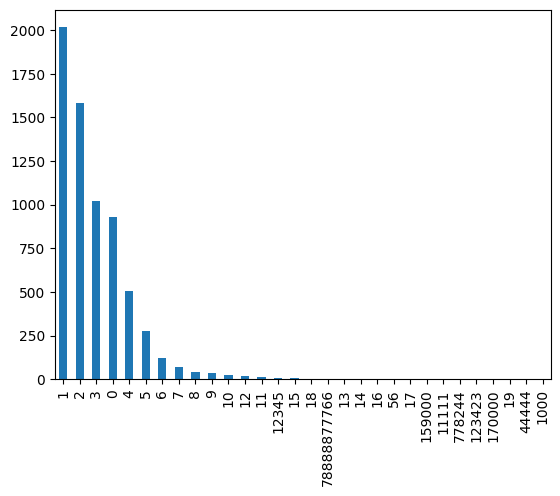

In [35]:
data_to_remove_outliers['prev_owners'].value_counts().plot.bar()

<AxesSubplot:>

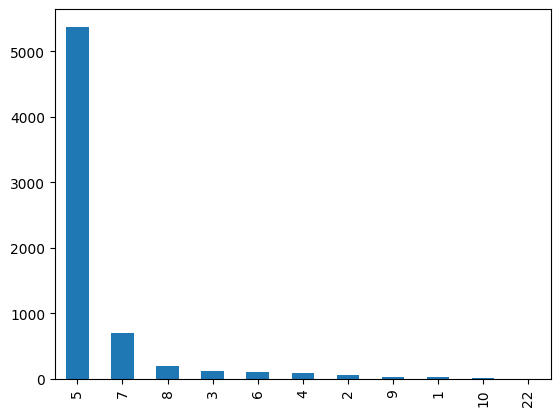

In [36]:
data_to_remove_outliers['passengers'].value_counts().plot.bar()

<AxesSubplot:>

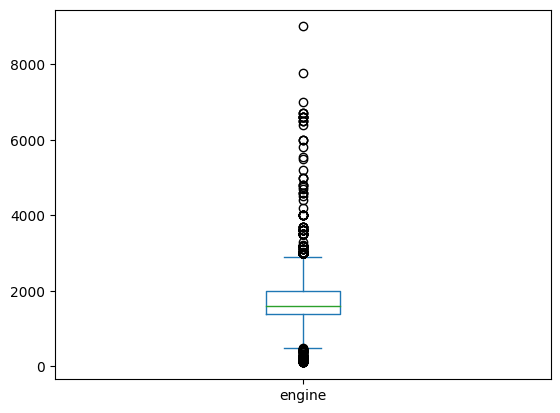

In [37]:
data_to_remove_outliers['engine'].plot.box()

<AxesSubplot:>

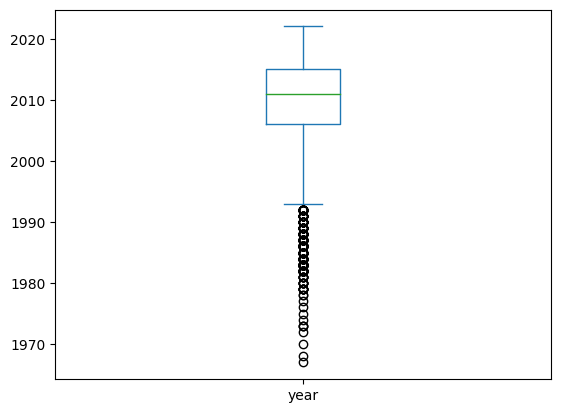

In [38]:
data_to_remove_outliers['year'].plot.box()

<AxesSubplot:>

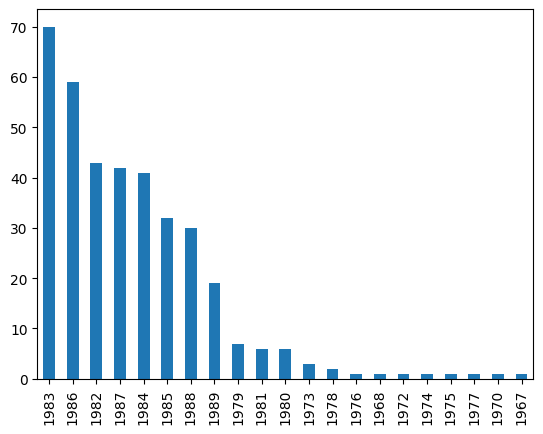

In [39]:
data_to_remove_outliers['year'][data_to_remove_outliers['year']< 1990].value_counts().plot.bar()

In [40]:
# remove outliers with quartiles for ['year', 'meter', 'prev_owners'] features
removed_outliers = detect_outlier_quartiles(data_to_remove_outliers, ['year', 'meter', 'prev_owners'])

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'prev_owners'}>]], dtype=object)

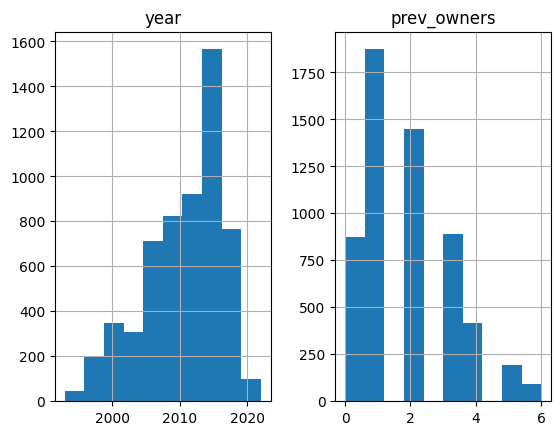

In [41]:
removed_outliers[['year', 'prev_owners']].hist()

<AxesSubplot:>

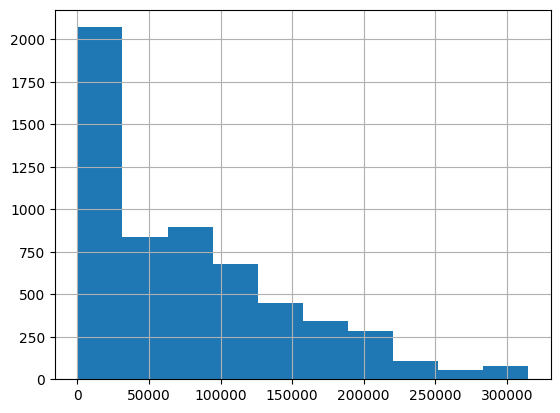

In [42]:
removed_outliers['meter'].hist()

In [43]:
# remove outliers with z-score for ['engine', 'passengers'] features
removed_outliers = detect_outlier_zscore(removed_outliers, ['engine', 'passengers'])

/var/folders/m1/fg0zsph94pj5b7vblgt01b580000gn/T/ipykernel_11549/4100762915.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[new_col >= (threshold*-1)]


array([[<AxesSubplot:title={'center':'engine'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'passengers'}>,
        <AxesSubplot:title={'center':'prev_owners'}>]], dtype=object)

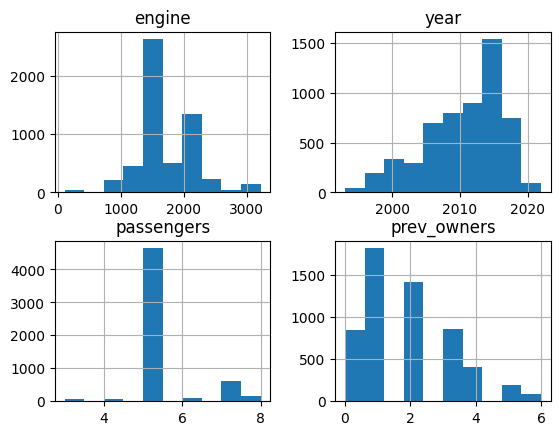

In [44]:
removed_outliers[features].hist()

In [45]:
removed_outliers.skew()

prev_owners      0.788942
passengers       1.579395
engine           0.486822
meter            0.909193
year            -0.690068
                  ...    
تجاري            6.949830
تدريب سياقة     15.233004
حكومي            8.808900
خصوصي           -2.241081
عمومي            3.317263
Length: 93, dtype: float64

# Normalize data 

In [46]:
# normalize data 
def normalize_features(data, column_names, normalizer):
    normalizer.fit(data[column_names])
    normalized_data = normalizer.transform(data[column_names])
    # save data back to the data frame
    data[column_names] = normalized_data
    
    return data

In [47]:
# normalize data with PowerTransformer
normalized_data = normalize_features(removed_outliers, features, PowerTransformer())

/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3211: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


array([[<AxesSubplot:title={'center':'engine'}>,
        <AxesSubplot:title={'center':'meter'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'passengers'}>],
       [<AxesSubplot:title={'center':'prev_owners'}>, <AxesSubplot:>]],
      dtype=object)

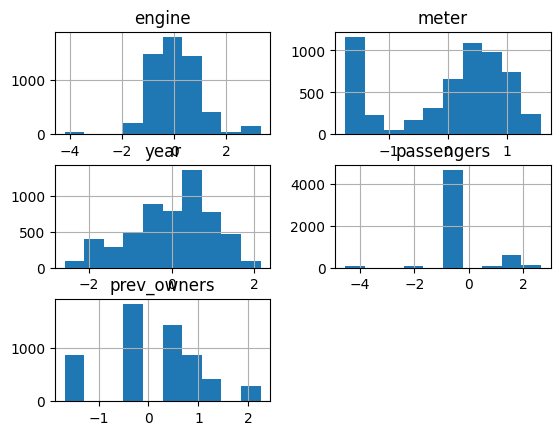

In [48]:
normalized_data[features].hist()

In [49]:
normalized_data.skew()

prev_owners     -0.025924
passengers      -0.204063
engine           0.211020
meter           -0.603324
year            -0.439824
                  ...    
تجاري            6.949830
تدريب سياقة     15.233004
حكومي            8.808900
خصوصي           -2.241081
عمومي            3.317263
Length: 93, dtype: float64

In [50]:
# save dataframe to handeled_data csv file 
normalized_data.to_csv("../csv-data/handeled_data.csv")

# evaluate models

In [51]:
# data to use: features  
# target : target variables ['price']
data_to_use = normalized_data.copy()
target = data_to_use['price']
data_to_use.drop('price', inplace = True, axis = 1)
data_to_use = data_to_use.reset_index(drop=True)

In [52]:
# x_train, x_test, y_train, y_test = train_test_split(data_to_use, target, test_size= 0.25, random_state= 41)

In [53]:
# evaluate KNN model 
# k = 17 return the model with max average of score  = 0.455
knn_scores = []
for k in range(1,30):   # running for different K values to know which yields the max accuracy. 
    clf = KNeighborsRegressor(n_neighbors = k,  weights = 'distance')
    scores = cross_val_score(clf, data_to_use, target, cv = 10)
    knn_scores.append(scores.mean())

print(knn_scores)

[0.05145019156890718, 0.2530020065852717, 0.3382859991151851, 0.3745978545200106, 0.39745943607913753, 0.41511362655197, 0.4242019348762921, 0.4290087278409871, 0.4352560261187685, 0.4397595411447888, 0.4451814066731803, 0.44806426504969316, 0.4503919844673591, 0.4496573500737773, 0.45181332242186906, 0.454169660426017, 0.4552175963150876, 0.4543219957278584, 0.45407982810987424, 0.4533252756667454, 0.4534759680045662, 0.4528365078430864, 0.4523305648750881, 0.45253764376624367, 0.45179792364937227, 0.45094630034246164, 0.4511655921033097, 0.4508186009373622, 0.45040810424484945]


In [54]:
lasso_score = cross_val_score(Lasso(tol = 1.582e+09 ), data_to_use, target, cv = 10)
lasso_score.mean()

0.40000095594612406

In [55]:
dt_score = cross_val_score(DecisionTreeRegressor(random_state=101, max_depth= 20), data_to_use, target, cv = 10)
dt_score.mean()

0.04367511175865282

In [56]:
# dict with all models to select model with best score
models=  { "ols": {"model": LinearRegression(),
                  "description":"orinary least square"},
        "sgd": {"model": SGDRegressor(),
                  "description":"gradient descent"},

        "poly2": {"model": LinearRegression(), "degree" : 2,
                  "description":"orinary least square with degree 2"},
         
         "linear_ridge": {"model": Ridge(), "degree" : 1,
                  "description":"degree 1 with ridge"},

        "linear_lasso": {"model": Lasso(tol=1.582e+09), "degree" : 1,
                  "description":"degree 1 with lasso"},

        "ply2_ridge": {"model": Ridge(), "degree" : 2,
                  "description":"degree 2 with ridge"},

        "ply2_lasso": {"model": Lasso(tol=1.582e+09), "degree" : 2,
                  "description":"degree 2 with lasso"},
        
         "KNN2": {"model": KNeighborsRegressor(n_neighbors = 17,  weights = 'distance'),
                  "description":"KNN with k=19"},

        "DT": {"model": DecisionTreeRegressor(random_state=0),
                  "description":"Desicion Tree "},
                 }


In [57]:
# train model function add score to models dict
def train_model(models, x_train, y_train):
    """
    models: dictionary
    {"model_id":{"model":which model, "description":""}}
    """
    
    # go over all models
    for model_id in models:
        # train if polynomial
        if  models[model_id].get("degree"):

            poly = PolynomialFeatures(models[model_id]['degree'])
            poly_x_train = poly.fit_transform(x_train)
            models[model_id]["score"] = cross_val_score(models[model_id]['model'], poly_x_train, y_train, cv = 10).mean()
            print(models[model_id])
        #train if not polynomial
        else:  
            models[model_id]["score"] = cross_val_score(models[model_id]['model'], x_train, y_train, cv = 10).mean()
            print(models[model_id])
    # return models

In [58]:
# train models
# the best returned score from KNN regressor with K=17
models = train_model(models, data_to_use, target)

{'model': LinearRegression(), 'description': 'orinary least square', 'score': -6.646750338824957e+20}
{'model': SGDRegressor(), 'description': 'gradient descent', 'score': 0.4420118210817135}
{'model': LinearRegression(), 'degree': 2, 'description': 'orinary least square with degree 2', 'score': -1.2001180061407019e+23}
{'model': Ridge(), 'degree': 1, 'description': 'degree 1 with ridge', 'score': 0.4471092963376739}
{'model': Lasso(tol=1582000000.0), 'degree': 1, 'description': 'degree 1 with lasso', 'score': 0.40000095594612406}
{'model': Ridge(), 'degree': 2, 'description': 'degree 2 with ridge', 'score': 0.39910454513977844}
{'model': Lasso(tol=1582000000.0), 'degree': 2, 'description': 'degree 2 with lasso', 'score': 0.41092229736156344}
{'model': KNeighborsRegressor(n_neighbors=17, weights='distance'), 'description': 'KNN with k=19', 'score': 0.4552175963150876}
{'model': DecisionTreeRegressor(random_state=0), 'description': 'Desicion Tree ', 'score': 0.008093955970697408}


In [100]:
# preprocessing step

numeric_transformer = PowerTransformer()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, slice(8, 13)),
        ("cat", categorical_transformer, slice(0,8)),
    ])


In [101]:
# create pipline with KNN model 
pipline = Pipeline(
    steps=[("preprocessor", preprocessor), ("Regressor", KNeighborsRegressor(n_neighbors=17))]
)

In [102]:
# prepare data to fit in pipline and drop null values
data_to_train = data_before_encode[all_used_cols].copy()
data_to_train.dropna(axis=0, how='any',  inplace=True)

In [103]:
# target_variable : price
# data_to_train : features 
target_variable = data_to_train['price']
data_to_train.drop('price', inplace = True, axis = 1)
data_to_train = data_to_train.reset_index(drop=True)

In [104]:
data_to_train

,color,fueil,license,name,gear,glass,weel_drive,prevـuse,prev_owners,passengers,engine,meter,year
9,أصفر,بنزين,فلسطينية,فولكسفاجن,عادي,يدوي,دفع أمامي,خصوصي,3.0,6,1600,50000,1979
10,أسود ميتالك,بنزين,فلسطينية,فولكسفاجن,اوتوماتيك,الكتروني,دفع أمامي,خصوصي,3.0,5,1400,180000,2010
11,أبيض,ديزل,فلسطينية,Dodge,اوتوماتيك,الكتروني,دفع رباعي 4x4,خصوصي,1.0,5,6700,120000,2015
12,أزرق,ديزل,فلسطينية,سيت,عادي,الكتروني,دفع رباعي 4x4,عمومي,4.0,5,1900,14,2001
13,ذهبي,بنزين,فلسطينية,هونداي,اوتوماتيك,الكتروني,دفع رباعي 4x4,خصوصي,6.0,5,1400,220000,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,أحمر,بنزين,فلسطينية,فيات,عادي,يدوي,دفع أمامي,خصوصي,2.0,5,1800,50000,1973
6860,أسود,ديزل,فلسطينية,هونداي,اوتوماتيك,الكتروني,دفع أمامي,خصوصي,2.0,7,2000,140,2016
6861,فضي,بنزين,فلسطينية,هونداي,اوتوماتيك,الكتروني,دفع أمامي,خصوصي,1.0,5,1400,40,2017
6862,أبيض,بنزين,فلسطينية,سكودا,اوتوماتيك,الكتروني,دفع أمامي,خصوصي,2.0,5,1200,60,2015


In [105]:
# fit data 
pipline.fit(data_to_train, target_variable)

/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3211: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/aleenkmail/Desktop/ML predict car price/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  slice(8, 13, None)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  slice(0, 8, None))])),
                ('Regressor', KNeighborsRegressor(n_neighbors=17))])

In [106]:
# pickle pipline 
pickle.dump(pipline, open('../pip_model.pkl','wb'))